In [1]:
import pandas as pd

In [2]:
def true_range(df): 
    '''
    df must be a pandas dataframe with high low and close column
    return a pandas series
    '''
    df['_tr1'] = df.high - df.low
    df['_tr2']  = (df.high - df.close.shift(1)).abs()
    df['_tr3']  = (df.low - df.close.shift(1)).abs()
    true_range = df[['_tr1','_tr2','_tr3']].max(axis=1)
    df.drop(df.columns[df.columns.str.startswith('_')], axis=1, inplace=True)
    return  true_range

In [3]:
def average_true_range(tr,n):
    '''
    tr is a pandas series
    return a pandas series
    '''
    return tr.ewm(com=n-1,adjust=False).mean()

In [4]:
def directional_movement(df):
    '''
    df must be a pandas dataframe with high low column
    return a tuple of pandas series up and down directional movement
    '''
    up_dm = df.high - df.high.shift(1)
    down_dm = df.low.shift(1) - df.low
    up_dm.mask(up_dm < 0,0,inplace=True)
    down_dm.mask(down_dm < 0,0,inplace=True)
    up_dm.mask(up_dm < down_dm,0,inplace=True)
    down_dm.mask(down_dm < up_dm, 0,inplace=True)
   
    return up_dm, down_dm

In [5]:
def average_directional_movement_index(df,n):
    '''
    df must be a pandas dataframe with high low  and close column
    return a tuple of pandas series adxr = the strength of a price movement
    '''
    up_dm, down_dm = directional_movement(df)
    tr = true_range(df)    
 
    up_DMn = up_dm.ewm(com=n-1,adjust=False).mean()
    
    down_DMn = down_dm.ewm(com=n-1,adjust=False).mean()
    TRn = tr.ewm(com=n-1,adjust=False).mean()
    up_DI = up_DMn/TRn
    down_DI = down_DMn/TRn

    DX = abs(up_DI- down_DI)/(up_DI + down_DI)
   
    ADX = DX.ewm(com=n-1,adjust=False).mean()
    ADXR = (ADX + ADX.shift(n-1)) / 2
    
    return ADXR

In [6]:
def rsi(close,n):
    '''
    close is a pandas series
    n is the period for smooth in exponential means
    return a pandas series as rsi
    '''
    
    delta = close - close.shift(1) 
    delta = delta.dropna()
    
    closeup = delta.mask(delta < 0, 0)
    closedown = delta.mask(delta > 0,0).abs()
    

    closeup[closeup.index[n-1]]= closeup[:n].mean()
    closeup = closeup.drop(closeup.index[:n-1])
    avg_closeup = closeup.ewm(com=n-1,adjust=False).mean() 

    closedown[closedown.index[n-1]]= closedown[:n].mean()
    closedown = closedown.drop(closedown.index[:n-1])
    avg_closedown = closedown.ewm(com=n-1,adjust=False).mean()

    rsi = avg_closeup / (avg_closedown + avg_closeup)

    return rsi

In [7]:
def z_units(values,n = 200):
    '''
    values is a pandas series, n is the period for mean and std
    return a pandas series
    '''
    return (values - values.rolling(200).mean())/values.rolling(200).std()

In [8]:
def normalize(values,n = 200):
    '''
        values is a pandas series, n is the period for mean and std
        return a pandas series
    '''
    return (values - values.rolling(200).min())/(values.rolling(200).max() - values.rolling(200).min())
    

In [9]:
min_period = 300
N = 14
df = pd.read_csv(f"data/USDT_BTC_{min_period}_1425168000_73.csv")
df.rename(columns={'date':'epoch','ts':'date'},inplace=True)
assert df.loc[0,'period'] == min_period, "Error, period different from min_period"
assert df['period'].count() == df.shape[0], "Error, period not always is min_period" 
df.drop(columns=['period','currency_pair','quoteVolume','weightedAverage'],inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by="date") #just in case
df.set_index('date',inplace=True)
df

,epoch,high,low,open,close,volume
date,,,,,,
2015-03-01 00:00:00,1425168000,240.000060,240.000060,240.000060,240.000060,0.000000
2015-03-01 00:05:00,1425168300,240.000060,240.000060,240.000060,240.000060,0.000000
2015-03-01 00:10:00,1425168600,240.000060,240.000060,240.000060,240.000060,0.000000
2015-03-01 00:15:00,1425168900,240.000060,240.000060,240.000060,240.000060,0.000000
2015-03-01 00:20:00,1425169200,240.000060,240.000060,240.000060,240.000060,0.000000
...,...,...,...,...,...,...
2021-03-31 23:35:00,1617233700,58802.587059,58761.857003,58801.000000,58762.000000,29415.195318
2021-03-31 23:40:00,1617234000,58798.268464,58744.683295,58762.000000,58795.050899,169054.589184
2021-03-31 23:45:00,1617234300,58866.551166,58795.050899,58795.050899,58810.585631,4315.762275


In [10]:

df['body'] = (df.close - df.open).abs()/(df.high - df.low) 
df['up_tail'] = (df.high - df[['close','open']].max(axis=1)) /(df.high - df.low) 
df['low_tail'] = (df[['close','open']].min(axis=1) - df.low) /(df.high - df.low) 
df['roc0'] = (df.close/df.open) - 1.0
df['roc1'] = df.close.pct_change(periods=1)
df['roc3'] = df.close.pct_change(periods=3)
df['roc7'] = df.close.pct_change(periods=7)
df['roc14'] = df.close.pct_change(periods=14)
df['roc28'] = df.close.pct_change(periods=28)
df['velocity'] = (df.close - df.open)/(df.epoch - df.epoch.shift(1))
df['avg_price'] = (df.close + df.open + df.high + df.low) / 4.0
df['base_volume'] = df.volume * df.avg_price
df['momentum'] = df.velocity * df.base_volume
df['real_momentum'] = df.momentum * df.body
df['sma50'] = df.close.rolling(50).mean()
df['delta_sma50'] = df.close - df.sma50
df['ema20'] = df.close.ewm(span=20).mean() 
df['delta_ema20'] = df.close - df.ema20
df['macd'] =  df.close.ewm(span=13).mean() - df.close.ewm(span=26).mean()
df['adxr'] = average_directional_movement_index(df,N)
df['rsi'] = rsi(df.close,N)

df.dropna(inplace=True)

df['macd_z'] = z_units(df.macd)
df['delta_ema20_z'] = z_units(df.delta_ema20,200)
df['delta_sma50_z'] = z_units(df.delta_sma50,200)
df['rsi_z'] =  z_units(df.rsi,200)
df['adxr_z'] =  z_units(df.adxr,200)
df['real_momentum_z'] = z_units(df.real_momentum,200)
df['momentum_z'] = z_units(df.momentum,200)
df['base_volume_z'] = z_units(df.base_volume,200)
df['velocity_z'] = z_units(df.velocity,200)
df['body_z'] = z_units(df.body,200)
df['up_tail_z'] = z_units(df.up_tail,200)
df['low_tail_z'] = z_units(df.low_tail,200)
df['roc0_z'] = z_units(df.roc0,200)
df['roc1_z'] = z_units(df.roc1,200)
df['roc3_z'] = z_units(df.roc3,200)
df['roc7_z'] = z_units(df.roc7,200)
df['roc14_z'] = z_units(df.roc14,200)
df['roc28_z'] = z_units(df.roc28,200)

df['macd_n'] = normalize(df.macd,200)
df['delta_ema20_n'] = normalize(df.delta_ema20,200)
df['delta_sma50_n'] = normalize(df.delta_sma50,200)
df['rsi_n'] =  normalize(df.rsi,200)
df['adxr_n'] =  normalize(df.adxr,200)
df['real_momentum_n'] = normalize(df.real_momentum,200)
df['momentum_n'] = normalize(df.momentum,200)
df['base_volume_n'] = normalize(df.base_volume,200)
df['velocity_n'] = normalize(df.velocity,200)
df['body_n'] = normalize(df.body,200)
df['up_tail_n'] = normalize(df.up_tail,200)
df['low_tail_n'] = normalize(df.low_tail,200)
df['roc0_n'] = normalize(df.roc0,200)
df['roc1_n'] = normalize(df.roc1,200)
df['roc3_n'] = normalize(df.roc3,200)
df['roc7_n'] = normalize(df.roc7,200)
df['roc14_n'] = normalize(df.roc14,200)
df['roc28_n'] = normalize(df.roc28,200)


In [11]:
df

,epoch,high,low,open,close,volume,body,up_tail,low_tail,roc0,...,velocity_n,body_n,up_tail_n,low_tail_n,roc0_n,roc1_n,roc3_n,roc7_n,roc14_n,roc28_n
date,,,,,,,,,,,,,,,,,,,,,
2015-03-02 18:15:00,1425320100,251.000005,251.000000,251.000005,251.000000,0.352238,1.000000,0.000000,0.000000,-2.007968e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-02 21:50:00,1425333000,269.000000,252.000000,252.000000,269.000000,97.412552,1.000000,0.000000,0.000000,6.746032e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-03 09:40:00,1425375600,274.000000,265.000000,265.000000,274.000000,118.599660,1.000000,0.000000,0.000000,3.396226e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-03 09:50:00,1425376200,265.000000,260.000000,265.000000,260.000000,27.783381,1.000000,0.000000,0.000000,-1.886792e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-03 09:55:00,1425376500,272.500000,260.000000,260.000000,260.000000,88.998148,0.000000,1.000000,0.000000,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 23:35:00,1617233700,58802.587059,58761.857003,58801.000000,58762.000000,29415.195318,0.957524,0.038965,0.003511,-6.632540e-04,...,0.728193,0.957497,0.039870,0.004069,0.726078,0.714409,0.711439,0.779562,0.726885,0.546509
2021-03-31 23:40:00,1617234000,58798.268464,58744.683295,58762.000000,58795.050899,169054.589184,0.616792,0.060046,0.323162,5.624536e-04,...,0.774670,0.616549,0.061440,0.374577,0.772781,0.775017,0.737719,0.797310,0.742502,0.577013
2021-03-31 23:45:00,1617234300,58866.551166,58795.050899,58795.050899,58810.585631,4315.762275,0.217268,0.782732,0.000000,2.642184e-04,...,0.763371,0.216772,0.800906,0.000000,0.761418,0.763421,0.724568,0.794837,0.782370,0.583724


In [12]:
df.rsi_z.describe()


count    491278.000000
mean          0.000300
std           1.054737
min          -5.695210
25%          -0.689893
50%           0.002142
75%           0.693200
max           5.866964
Name: rsi_z, dtype: float64

<AxesSubplot:>

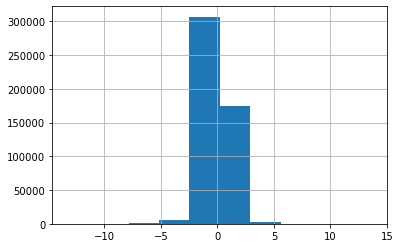

In [13]:
df.roc0_z.hist()

In [18]:
df.base_volume_n.describe()

count    491278.000000
mean          0.104706
std           0.153679
min           0.000000
25%           0.013318
50%           0.049251
75%           0.129666
max           1.000000
Name: base_volume_n, dtype: float64

In [14]:
daily_df = df.resample('D').agg({'epoch':'first','high':'max','low':'min','open':'first','close':'last','volume':'sum'})

In [15]:
df['body_day'] = (daily_df.close - daily_df.open).abs()/(daily_df.high - daily_df.low) 
df['up_tail_day'] = (daily_df.high - daily_df[['close','open']].max(axis=1)) /(daily_df.high - daily_df.low) 
df['low_tail_day'] = (daily_df[['close','open']].min(axis=1) - daily_df.low) /(daily_df.high - daily_df.low) 
df['roc0_day'] = (daily_df.close/daily_df.open) - 1.0
df['velocity_day'] = (daily_df.close - daily_df.open)/(daily_df.epoch - daily_df.epoch.shift(1))
df['avg_price_day'] = (daily_df.close + daily_df.open + daily_df.high + daily_df.low) / 4.0
df['base_volume_day'] = daily_df.volume * df.avg_price_day
df['momentum_day'] = df.velocity_day *  df.base_volume_day
df['real_momentum_day'] = df.momentum_day * df.body_day
df['adxr_day'] = average_directional_movement_index(daily_df,N)
df['rsi_day'] = rsi(daily_df.close,N)

In [16]:
df.fillna(method='ffill',inplace=True)
df

,epoch,high,low,open,close,volume,body,up_tail,low_tail,roc0,...,up_tail_day,low_tail_day,roc0_day,velocity_day,avg_price_day,base_volume_day,momentum_day,real_momentum_day,adxr_day,rsi_day
date,,,,,,,,,,,,,,,,,,,,,
2015-03-02 18:15:00,1425320100,251.000005,251.000000,251.000005,251.000000,0.352238,1.000000,0.000000,0.000000,-2.007968e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-02 21:50:00,1425333000,269.000000,252.000000,252.000000,269.000000,97.412552,1.000000,0.000000,0.000000,6.746032e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-03 09:40:00,1425375600,274.000000,265.000000,265.000000,274.000000,118.599660,1.000000,0.000000,0.000000,3.396226e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-03 09:50:00,1425376200,265.000000,260.000000,265.000000,260.000000,27.783381,1.000000,0.000000,0.000000,-1.886792e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-03 09:55:00,1425376500,272.500000,260.000000,260.000000,260.000000,88.998148,0.000000,1.000000,0.000000,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 23:35:00,1617233700,58802.587059,58761.857003,58801.000000,58762.000000,29415.195318,0.957524,0.038965,0.003511,-6.632540e-04,...,0.352352,0.64606,-0.000079,-0.000054,58530.089945,3.513689e+12,-1.896121e+08,-301115.185246,0.218225,0.604062
2021-03-31 23:40:00,1617234000,58798.268464,58744.683295,58762.000000,58795.050899,169054.589184,0.616792,0.060046,0.323162,5.624536e-04,...,0.352352,0.64606,-0.000079,-0.000054,58530.089945,3.513689e+12,-1.896121e+08,-301115.185246,0.218225,0.604062
2021-03-31 23:45:00,1617234300,58866.551166,58795.050899,58795.050899,58810.585631,4315.762275,0.217268,0.782732,0.000000,2.642184e-04,...,0.352352,0.64606,-0.000079,-0.000054,58530.089945,3.513689e+12,-1.896121e+08,-301115.185246,0.218225,0.604062
